# Extra Credit: DCGAN for QuickDraw *Cat* Sketches (Fast Version)

This notebook trains a DCGAN to generate cat sketches using a subset of the QuickDraw dataset. It is fast (5,000 images, 5 epochs) and suitable for extra credit experiments. Edit for more epochs or categories as needed!

### Install all required Python libraries
This cell installs the necessary packages for deep learning, plotting, and data loading.

In [2]:
# Install dependencies for PyTorch, torchvision, numpy, matplotlib, requests, tqdm
!pip install torch torchvision numpy matplotlib requests tqdm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.0 MB/s eta 0:00:00


## 1. Download and Explore the QuickDraw Cat Dataset
This cell downloads the 'cat' QuickDraw category if needed, loads the npy file, and displays 10 random examples.

Download complete.
Loaded 123202 cat images of shape (784,)
Using subset: 5000 images


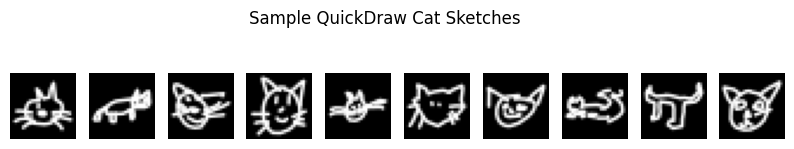

In [3]:
import numpy as np  # Import numpy for numerical operations and loading npy files
import matplotlib.pyplot as plt  # For plotting images and figures
import requests  # For downloading the dataset
import os  # For file operations like checking if file exists

cat_url = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cat.npy"  # URL to download cat QuickDraw data
filename = "cat.npy"  # Name for the local file to store data
if not os.path.exists(filename):  # Check if file already exists
    print("Downloading cat dataset...")  # Inform user
    r = requests.get(cat_url)  # Download file from url
    with open(filename, "wb") as f:  # Open file in write-binary mode
        f.write(r.content)  # Write the content to the file
    print("Download complete.")  # Inform user

images = np.load(filename)  # Load the npy file into a numpy array
print(f"Loaded {images.shape[0]} cat images of shape {images.shape[1:]}")  # Show how many images loaded

# Use only a subset for speed
images = images[:5000]  # Keep first 5000 images for fast training
print(f"Using subset: {images.shape[0]} images")  # Display subset size

plt.figure(figsize=(10,2))  # Make a wide figure for showing 10 images
for i in range(10):  # Loop through first 10 images
    plt.subplot(1,10,i+1)  # Make a row of 10 subplots
    plt.imshow(images[i].reshape(28,28), cmap='gray')  # Show image reshaped to 28x28
    plt.axis('off')  # Hide axes
plt.suptitle("Sample QuickDraw Cat Sketches")  # Add a title above all images
plt.show()  # Display the figure

## 2. Prepare Dataset for PyTorch
This cell wraps the numpy image data into a PyTorch Dataset and DataLoader, normalizing pixel values to [-1, 1].

In [4]:
import torch  # Import PyTorch for deep learning
from torch.utils.data import Dataset, DataLoader  # For creating datasets and batching

class QuickDrawDataset(Dataset):  # Custom dataset for QuickDraw images
    def __init__(self, npy_data):  # Constructor takes numpy array
        self.data = npy_data.astype(np.float32) / 255.0  # Normalize to [0,1] float
        self.data = (self.data - 0.5) / 0.5              # Shift to [-1,1] (needed for DCGAN)
    def __len__(self):  # Return number of samples
        return len(self.data)
    def __getitem__(self, idx):  # Get one sample (as tensor)
        img = self.data[idx].reshape(1,28,28)            # Reshape to (1, 28, 28) - 1 channel
        return torch.tensor(img)  # Return as PyTorch tensor

qd_dataset = QuickDrawDataset(images)  # Create dataset instance
dataloader = DataLoader(qd_dataset, batch_size=64, shuffle=True, drop_last=True)  # Batch data for training

## 3. Define DCGAN Generator and Discriminator
This cell defines the generator and discriminator neural network architectures used for the DCGAN.

In [5]:
import torch.nn as nn  # Import nn for neural network layers

# Define the generator network
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64):  # nz: latent vector size, ngf: feature maps
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*4, 7, 1, 0, bias=False), # (batch, ngf*4, 7, 7)
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False), # (batch, ngf*2, 14, 14)
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, 1, 4, 2, 1, bias=False),     # (batch, 1, 28, 28)
            nn.Tanh()  # Output in [-1,1]
        )
    def forward(self, input):  # Forward method
        return self.main(input)

# Define the discriminator network
class Discriminator(nn.Module):
    def __init__(self, ndf=64):  # ndf: feature maps
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, ndf, 4, 2, 1, bias=False),  # (batch, ndf, 14, 14)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),  # (batch, ndf*2, 7, 7)
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),  # Flatten to (batch, ndf*2*7*7)
            nn.Linear(ndf*2*7*7, 1),  # Final output layer
            nn.Sigmoid()  # Output probability [0,1]
        )
    def forward(self, input):  # Forward method
        return self.main(input)

## 4. Initialize Models, Loss, and Optimizers
This cell sets up the generator and discriminator, moves them to GPU if available, and defines the optimizer and loss function.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

netG = Generator().to(device)  # Create generator and move to device
netD = Discriminator().to(device)  # Create discriminator and move to device

criterion = nn.BCELoss()  # Binary Cross Entropy loss for GANs
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))  # Adam optimizer for D
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))  # Adam optimizer for G

nz = 100  # Latent vector size (input to generator)
fixed_noise = torch.randn(16, nz, 1, 1, device=device)  # Same noise to visualize progress

## 5. Train the DCGAN (Fast Version, 5 Epochs)
This cell trains the DCGAN for 5 epochs. Losses are recorded, and generated samples are shown at the end.

Epoch 1/5:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/78 [00:00<?, ?it/s]

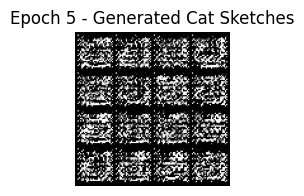

Epoch 5: Generator Loss 7.1583, Discriminator Loss 0.0014


In [7]:
from tqdm.notebook import tqdm  # For progress bars
import torchvision  # For utility functions (make_grid)

num_epochs = 5  # Number of training epochs
G_losses, D_losses, img_list = [], [], []  # Lists to store losses and generated images

for epoch in range(1, num_epochs+1):  # Loop over epochs
    for real_imgs in tqdm(dataloader, desc=f"Epoch {epoch}/{num_epochs}"):  # Loop over batches
        real_imgs = real_imgs.to(device)  # Move real images to device
        b_size = real_imgs.size(0)  # Get batch size
        # Update Discriminator
        netD.zero_grad()  # Zero gradients for D
        real_labels = torch.ones(b_size, 1, device=device)  # Real label=1
        fake_labels = torch.zeros(b_size, 1, device=device)  # Fake label=0
        output = netD(real_imgs).view(-1, 1)  # D output for real images
        lossD_real = criterion(output, real_labels)  # D loss on real
        noise = torch.randn(b_size, nz, 1, 1, device=device)  # Random noise for G
        fake_imgs = netG(noise)  # Generate fake images
        output = netD(fake_imgs.detach()).view(-1, 1)  # D output for fake, detached to not backprop to G
        lossD_fake = criterion(output, fake_labels)  # D loss on fake
        lossD = lossD_real + lossD_fake  # Total D loss
        lossD.backward()  # Backprop D
        optimizerD.step()  # Update D params
        # Update Generator
        netG.zero_grad()  # Zero gradients for G
        output = netD(fake_imgs).view(-1, 1)  # D output on fake images (not detached)
        lossG = criterion(output, real_labels)  # G loss (wants D to think fake is real)
        lossG.backward()  # Backprop G
        optimizerG.step()  # Update G params
    G_losses.append(lossG.item())  # Record generator loss
    D_losses.append(lossD.item())  # Record discriminator loss
    if epoch == num_epochs:  # At last epoch, visualize generated images
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()  # Generate images from fixed noise
        img_grid = torchvision.utils.make_grid(fake, nrow=4, normalize=True)  # Make grid of 16 images
        img_list.append(img_grid)  # Add to list
        plt.figure(figsize=(5, 2))
        plt.axis("off")
        plt.title(f"Epoch {epoch} - Generated Cat Sketches")
        plt.imshow(np.transpose(img_grid, (1, 2, 0)), cmap="gray")  # Show grid
        plt.show()
        print(f"Epoch {epoch}: Generator Loss {lossG.item():.4f}, Discriminator Loss {lossD.item():.4f}")

## 6. Plot Training Losses
This cell visualizes generator and discriminator loss curves over training epochs.

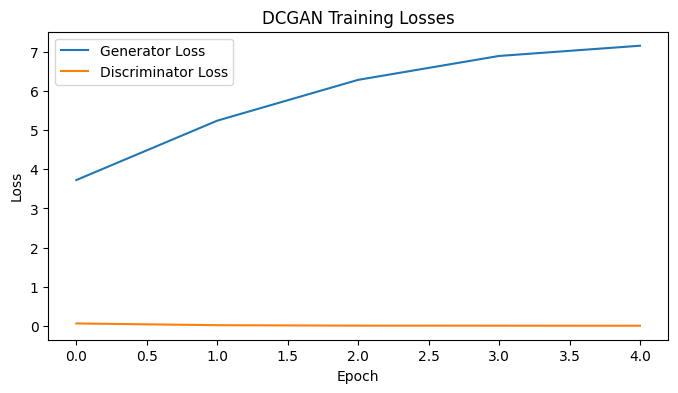

In [8]:
plt.figure(figsize=(8,4))  # Set figure size
plt.plot(G_losses, label="Generator Loss")  # Plot G loss
plt.plot(D_losses, label="Discriminator Loss")  # Plot D loss
plt.xlabel("Epoch")  # Label x-axis
plt.ylabel("Loss")  # Label y-axis
plt.title("DCGAN Training Losses")  # Title
plt.legend()  # Add legend
plt.show()  # Show plot

## 7. Visual Comparison: Real vs. Fake Cat Sketches
This cell displays a set of real cat sketches and generated cat sketches for visual comparison.

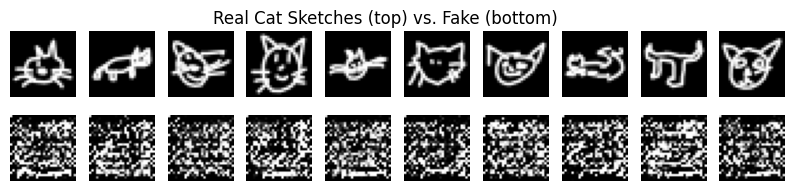

In [9]:
# Show real images
plt.figure(figsize=(10,2))  # Set wide figure
for i in range(10):  # Top row: real images
    plt.subplot(2,10,i+1)
    plt.imshow(images[i].reshape(28,28), cmap='gray')
    plt.axis('off')
plt.suptitle("Real Cat Sketches (top) vs. Fake (bottom)")

# Show generated images (from last epoch)
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
for i in range(10):  # Bottom row: generated images
    plt.subplot(2,10,10+i+1)
    plt.imshow(fake[i][0], cmap='gray')
    plt.axis('off')
plt.show()

# **Discussion: Model Performance on Cat Sketches**

- The DCGAN learns to draw basic cat shapes, but details (whiskers, ears, faces) may be blurry with few epochs and small dataset.
- Cat sketches are more complex than smiley faces, so more training (epochs & data) improves results.
- Try running longer or with all 70,000+ images for clearer, more recognizable cats.
- We can repeat this notebook for other categories (e.g., "house") by changing the download URL and filename.
